In [ ]:
Xinhao Lan (1082620)

# Lab 3: Constituency parsing with CKY

### Natural Language Processing, 2022


The grammatical structure of a sentence can be represented with a Context Free Grammar (CFG). When we additionally assign probabilities to the rules of the CFG we get a PCFG: a _Probabilistic_ CFG. 

Given a sufficiently expressive PCFG (one that holds enough rules) we can parse new sentences using the Cocke–Kasami–Younger (CKY) algorithm. You can use this algorithm in three ways: to find the set of all the possible parses $p$ of a sentence $s$ under a PCFG $G$; to find the probability of the sentence by summing up the probabilities of these parses; or to find the parse $p^{*}$ of the highest probability.


### Tasks
1. In this notebook you will learn how to represent a PCFG in an object-oriented manner as a collection of python classes. These classes are already defined for you. Read them through thoroughly and make sure that you understand them well. You have to use them in task 2.

2. Implement the CKY algorithm to find the most probable parse $p^{*}$ for a sentence. Your implementation will follow the psuedo-code that is given in both the lecture slides, and Jurafsky and Martin.

The reference for this notebook is chapters 13 and 14 of [Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/) (both in the 2nd and 3rd edition) and the slides from week 4.


------

### Rules
* The lab exercises should be made in **groups of two people**.

* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**!

* The **filename** should be `lab2_id1_id2.ipynb`, e.g., `lab3_1234567_7654321.ipynb`.

* The notebook is graded on a scale of **0-100**. The number of points for each question is indicated in parantheses.


Notes on implementation:

* You should **write your code and answers in this iPython Notebook** (see http://ipython.org/notebook.html for reference material). If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `# YOUR CODE HERE` comment.
    
    * For theoretical questions, put your solution in the YOUR ANSWER HERE cell.
    
* Test your code and **make sure we can run your notebook**

* For some sections in this notebook, you will need to have the Natural Language Toolkit ([NLTK](http://www.nltk.org/)) installed. We will use a feature of the NLTK toolkit that lets you draw constituency parses. Details for download can be found here: http://www.nltk.org/install.html.

------

In [ ]:
import numpy as np
from collections import Counter, defaultdict
import math
import nltk
from nltk.tree import Tree

In [ ]:
import queue

# 1. PCFG

In this lab we will show you a way to represent a **PCFG** using python objects. We will introduce the following classes:

* Symbol
    * Terminal
    * Nonterminal
* Rule

At first glance, this might seem like a lot of work. But, hopefully, by the time you get to implementing CKY you will be confinced of the benefits of these constructions.

## Symbol

Recall that:
* **Terminal** symbols are the words of the sentence: _I, ate, salad, the_ etc.
* **Nonterminal** symbols are the syntactic categories of the various constituents: _S, NP, VP, Det_ etc.

In our representation, `Symbol` is going to be a container class. The classes `Terminal` and `Nonterminal` will *inherit* from the `Symbol` class and will hence both become a type of symbol. The classes themselves are effectively a container for the underlying python strings. 

In [ ]:
class Symbol:
    """
    A symbol in a grammar.
    This class will be used as parent class for Terminal, Nonterminal.
    This way both will be a type of Symbol.
    """
    def __init__(self):
        pass


class Terminal(Symbol):
    """
    Terminal symbols are words in a vocabulary
    
    E.g. 'I', 'ate', 'salad', 'the'
    """

    def __init__(self, symbol: str):
        assert type(symbol) is str, 'A Terminal takes a python string, got %s' % type(symbol)
        self._symbol = symbol

    def is_terminal(self):
        return True

    def is_nonterminal(self):
        return False

    def __str__(self):
        return "'%s'" % self._symbol

    def __repr__(self):
        return 'Terminal(%r)' % self._symbol

    def __hash__(self):
        return hash(self._symbol)

    def __len__(self):
        """The length of the underlying python string"""
        return len(self._symbol)

    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol

    def __ne__(self, other):
        return not (self == other)
    
    @property
    def obj(self):
        """Returns the underlying python string"""
        return self._symbol


class Nonterminal(Symbol):
    """
    Nonterminal symbols are the grammatical classes in a grammar.
    
    E.g. S, NP, VP, N, Det, etc.
    """

    def __init__(self, symbol: str):
        assert type(symbol) is str, 'A Nonterminal takes a python string, got %s' % type(symbol)
        self._symbol = symbol

    def is_terminal(self):
        return False
    
    def is_nonterminal(self):
        return True

    def __str__(self):
        return "[%s]" % self._symbol

    def __repr__(self):
        return 'Nonterminal(%r)' % self._symbol

    def __hash__(self):
        return hash(self._symbol)
    
    def __len__(self):
        """The length of the underlying python string"""
        return len(self._symbol)
    
    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol

    def __ne__(self, other):
        return not (self == other)
    
    @property
    def obj(self):
        """Returns the underlying python string"""
        return self._symbol


Let's try out the classes by initializing some terminal and nonterminal symbols:

In [ ]:
dog = Terminal('dog')
the = Terminal('the')
walks = Terminal('walks')

S = Nonterminal('S')
NP = Nonterminal('NP')
NP_prime = Nonterminal('NP')
VP = Nonterminal('VP')
V = Nonterminal('V')
N = Nonterminal('N')
Det = Nonterminal('Det')

The methods `__eq__` and `__ne__` make it possible to compare our objects using standard Python syntax. But more importantly: compare in the way that we are interested in, namely whether the underlying representation is the same.

To see the difference, try commenting out the method `__eq__` in the class above, and notice the different result of the equality test `NP==NP_prime`.

In [ ]:
print(dog)
print(NP)
print()
print(NP==Det)
print(NP!=Det)
print(NP==NP)
print(NP==NP_prime)

'dog'
[NP]

False
True
True
True


Note the difference between calling `print(NP)` and simply calling `NP`. The first is taken care of by the method `__str__` and the second by the method `__repr__`.

In [ ]:
dog

Terminal('dog')

We can also easily check if our symbol is a terminal or not:

In [ ]:
dog.is_terminal()

True

In [ ]:
NP.is_terminal()

False

Finally the method `__hash__` makes our object *hashable*, and hence usable in a datastructure like a dictionary. 

Try commenting out this method above in the class and then retry constructing the dictionary: notice the error.

In [ ]:
d = {NP: 1, S: 2}
d

{Nonterminal('NP'): 1, Nonterminal('S'): 2}

## Rules

In a PCFG a **rule** looks something like this 

$$NP \to Det\;N,$$

with a corresponding probability, for example $1.0$ if we lived in a world where all noun phrases had this grammatical structure.

In our representation, `Rule` will be an object made of a left-hand side (`lhs`) symbol, a sequence of right-hand side symbols (`rhs`) and a probability `prob`. 

If we use the above defined symbols, we can call

    rule = Rule(NP, [Det, N], 1.0).
   
This will construct an instance called `rule` which represent the rule above

    [NP] -> [Det] [N] (1.0).
    

In [ ]:
class Rule:

    def __init__(self, lhs, rhs, prob):
        """
        Constructs a Rule.
        A Rule takes a LHS symbol and a list/tuple of RHS symbols.

        :param lhs: the LHS nonterminal
        :param rhs: a sequence of RHS symbols (terminal or nonterminal)
        :param prob: probability of the rule
        """

        assert isinstance(lhs, Symbol), 'LHS must be an instance of Symbol'
        assert len(rhs) > 0, 'If you want an empty RHS, use an epsilon Terminal EPS'
        assert all(isinstance(s, Symbol) for s in rhs), 'RHS must be a sequence of Symbol objects'
        self._lhs = lhs
        self._rhs = tuple(rhs)
        self._prob = prob


    def __eq__(self, other):
        return self._lhs == other._lhs and self._rhs == other._rhs and self._prob == other._prob

    def __ne__(self, other):
        return not (self == other)

    def __hash__(self):
        return hash((self._lhs, self._rhs, self._prob))

    def __repr__(self):
        return '%s -> %s (%s)' % (self._lhs,
                ' '.join(str(sym) for sym in self._rhs),
                self.prob)

    def is_binary(self):
        """True if Rule is binary: A -> B C"""
        return len(self._rhs) == 2
    
    def is_unary(self):
        """True if Rule is unary: A -> w"""
        return len(self._rhs) == 1
    
    @property
    def lhs(self):
        """Returns the lhs of the rule"""
        return self._lhs

    @property
    def rhs(self):
        """Returns the rhs of the rule"""
        return self._rhs

    @property
    def prob(self):
        """Returns the probability of the rule"""
        return self._prob


Just as with `Terminal` and `Nonterminal` you can print an instance of `Rule`, you can access its attributes, and you can hash rules with containers such as dict and set.

In [ ]:
r1 = Rule(S, [NP, VP], 1.0)
r2 = Rule(NP, [Det, N], 1.0)
r3 = Rule(N, [dog], 1.0)
r4 = Rule(Det, [the], 1.0)
r5 = Rule(VP, [walks], 1.0)

print(r1)
print(r2)
print(r3)
print(r4)

[S] -> [NP] [VP] (1.0)
[NP] -> [Det] [N] (1.0)
[N] -> 'dog' (1.0)
[Det] -> 'the' (1.0)


In [ ]:
print(r1.prob)

1.0


In [ ]:
r1 in set([r1])

True

In [ ]:
d = {r1: 1, r2: 2}
d

{[NP] -> [Det] [N] (1.0): 2, [S] -> [NP] [VP] (1.0): 1}

## Grammar

A `PCFG` class is a container for `Rules`. The `Rules` are stored in the `PCFG` in such a way that they can be accesed easily in different ways.

In [ ]:
class PCFG(object):
    """
    Constructs a PCFG.
    A PCFG stores a list of rules that can be accessed in various ways.
    
    :param rules: an optional list of rules to initialize the grammar with
    """
    def __init__(self, rules=[]):
        self._rules = []
        self._rules_by_lhs = defaultdict(list)
        self._terminals = set()
        self._nonterminals = set()
        for rule in rules:
            self.add(rule)

    def add(self, rule):
        """Adds a rule to the grammar"""
        if not rule in self._rules:
            self._rules.append(rule)
            self._rules_by_lhs[rule.lhs].append(rule)
            self._nonterminals.add(rule.lhs)
            for s in rule.rhs:
                if s.is_terminal():
                    self._terminals.add(s)
                else:
                    self._nonterminals.add(s)

    def update(self, rules):
        """Add a list of rules to the grammar"""
        for rule in rules:
            self.add(rule)

    @property
    def nonterminals(self):
        """The list of nonterminal symbols in the grammar"""
        return self._nonterminals

    @property
    def terminals(self):
        """The list of terminal symbols in the grammar"""
        return self._terminals
    
    @property
    def rules(self):
        """The list of rules in the grammar"""
        return self._rules
    
    @property
    def binary_rules(self):
        """The list of binary rules in the grammar"""
        return [rule for rule in self._rules if rule.is_binary()]
    
    @property
    def unary_rules(self):
        """The list of unary rules in the grammar"""
        return [rule for rule in self._rules if rule.is_unary()]

    def __len__(self):
        return len(self._rules)

    def __getitem__(self, lhs):
        return self._rules_by_lhs.get(lhs, frozenset())

    def get(self, lhs, default=frozenset()):
        """The list of rules whose LHS is the given symbol lhs"""
        return self._rules_by_lhs.get(lhs, frozenset())

    def __iter__(self):
        """Iterator over rules (in arbitrary order)"""
        return iter(self._rules)

    def iteritems(self):
        """Iterator over pairs of the kind (LHS, rules rewriting LHS)"""
        return self._rules_by_lhs.items()

    def __str__(self):
        """Prints the grammar line by line"""
        lines = []
        for lhs, rules in self.iteritems():
            for rule in rules:
                lines.append(str(rule))
        return '\n'.join(lines)


Initialize a grammar

In [ ]:
G = PCFG()

We can add rules individually with `add`, or as a list with `update`:

In [ ]:
G.add(r1)
G.update([r2,r3,r4,r5])

We can print the grammar

In [ ]:
print(G)

[S] -> [NP] [VP] (1.0)
[NP] -> [Det] [N] (1.0)
[N] -> 'dog' (1.0)
[Det] -> 'the' (1.0)
[VP] -> 'walks' (1.0)


We can get the set of rewrite rules for a certain LHS symbol.

In [ ]:
G.get(S)

[[S] -> [NP] [VP] (1.0)]

In [ ]:
G.get(NP)

[[NP] -> [Det] [N] (1.0)]

We can also iterate through rules in the grammar.

Note that the following is basically counting how many rules we have in the grammar.

In [ ]:
sum(1 for r in G)

5

which can also be done in a more efficient way

In [ ]:
len(G)

5

We can access the set of terminals and nonterminals of the grammar:

In [ ]:
print(G.nonterminals)

{Nonterminal('Det'), Nonterminal('N'), Nonterminal('NP'), Nonterminal('VP'), Nonterminal('S')}


In [ ]:
print(G.terminals)

{Terminal('dog'), Terminal('the'), Terminal('walks')}


In [ ]:
S in G.nonterminals

True

In [ ]:
dog in G.terminals

True

Finally we can easily access all the binary rules and all the unary rules in the grammar:

In [ ]:
G.unary_rules

[[N] -> 'dog' (1.0), [Det] -> 'the' (1.0), [VP] -> 'walks' (1.0)]

In [ ]:
G.binary_rules

[[S] -> [NP] [VP] (1.0), [NP] -> [Det] [N] (1.0)]

------
For the following sections you will need to have the Natural Language Toolkit ([NLTK](http://www.nltk.org/)) installed. We will use a feature of the NLTK toolkit that lets you draw constituency parses. Details for download can be found here: http://www.nltk.org/install.html.

----------



# Visualizing a tree

For the sake of legacy let's reiterate an age-old NLP schtick, the well-known example of structural ambiguity from the Groucho Marx movie, [Animal Crackers](https://youtu.be/FZUfhfHbjE4?t=1m33s) (1930):

> One morning I shot an elephant in my pajamas. How he got into my pajamas, I don't know.

Let's take a closer look at the ambiguity in the phrase: _I shot an elephant in my pajamas_. The ambiguity is caused by the fact that the sentence has two competing parses represented in:

    (S (NP I) (VP (VP (V shot) (NP (Det an) (N elephant))) (PP (P in) (NP (Det my) (N pajamas)))))

and

    (S (NP I) (VP (V shot) (NP (Det an) (NP (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))))


We can write these parses down as strings and then let NLTK turn them into trees using the NLTK `Tree` class. (See http://www.nltk.org/api/nltk.html#nltk.tree.Tree as reference for this class, if you want to know more.)

In [ ]:
parse1 = "(S (NP I) (VP (VP (V shot) (NP (Det an) (N elephant))) (PP (P in) (NP (Det my) (N pajamas)))))"
parse2 = "(S (NP I) (VP (V shot) (NP (Det an) (NP (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))))"

pajamas1 = Tree.fromstring(parse1)
pajamas2 = Tree.fromstring(parse2)

We can then *pretty-print* these trees:

In [ ]:
pajamas1.pretty_print()
pajamas2.pretty_print()

     S                                       
  ___|______________                          
 |                  VP                       
 |         _________|__________               
 |        VP                   PP            
 |    ____|___              ___|___           
 |   |        NP           |       NP        
 |   |     ___|_____       |    ___|_____     
 NP  V   Det        N      P  Det        N   
 |   |    |         |      |   |         |    
 I  shot  an     elephant  in  my     pajamas

     S                                       
  ___|__________                              
 |              VP                           
 |    __________|______                       
 |   |                 NP                    
 |   |     ____________|___                   
 |   |    |                NP                
 |   |    |      __________|___               
 |   |    |     |              PP            
 |   |    |     |       _______|___           
 |   |    |     |      

# Parsing with CKY

Let's stick with this sentence for the rest of this lab. We will use CKY to find the 'best' parse for this sentence.

In [ ]:
# Turn the sentence into a list
sentence = "I shot an elephant in my pajamas".split()
# The length of the sentence
num_words = len(sentence)

A PCFG for this sentence can be found in the file `groucho-grammar-1.txt`. We read this in with the function `read_grammar_rules`.

In [ ]:
def read_grammar_rules(istream):
    """Reads grammar rules formatted as 'LHS ||| RHS ||| PROB'."""
    for line in istream:
        line = line.strip()
        if not line:
            continue
        fields = line.split('|||')
        if len(fields) != 3:
            raise ValueError('I expected 3 fields: %s', fields)
        lhs = fields[0].strip()

        if lhs[0] == '[':
            lhs = Nonterminal(lhs[1:-1])
        else:
            lhs = Terminal(lhs)
        rhs = fields[1].strip().split()
        new_rhs = []
        for r in rhs:
            if r[0] == '[':
                r = Nonterminal(r[1:-1])
            else:
                r = Terminal(r)
            new_rhs.append(r)

        prob = float(fields[2].strip())
        yield Rule(lhs, new_rhs, prob)

In [ ]:
# Read in the grammar
istream = open('groucho-grammar-1.txt')
grammar = PCFG(read_grammar_rules(istream))
print("The grammar:\n", grammar, "\n")

The grammar:
 [S] -> [NP] [VP] (1.0)
[PP] -> [P] [NP] (1.0)
[NP] -> [Det] [N] (0.2)
[NP] -> [Det] [NP] (0.3)
[NP] -> [N] [PP] (0.3)
[NP] -> 'I' (0.2)
[VP] -> [V] [NP] (0.4)
[VP] -> [VP] [PP] (0.6)
[Det] -> 'an' (0.6)
[Det] -> 'my' (0.4)
[N] -> 'elephant' (0.5)
[N] -> 'pajamas' (0.5)
[V] -> 'shot' (1.0)
[P] -> 'in' (1.0) 



We will also need the following two dictionaries: `nonterminal2index` mapping from nonterminals to integers (indices); and its inverse, an `index2nonterminal` dictionary.

In [ ]:
num_nonterminals = len(grammar.nonterminals)

# Make a nonterminal2index and a index2nonterminal dictionary
n2i = defaultdict(lambda: len(n2i))
i2n = dict()
for A in grammar.nonterminals:
    i2n[n2i[A]] = A

# Stop defaultdict behavior of n2i
n2i = dict(n2i)

n2i

{Nonterminal('Det'): 1,
 Nonterminal('NP'): 2,
 Nonterminal('N'): 3,
 Nonterminal('PP'): 7,
 Nonterminal('P'): 5,
 Nonterminal('S'): 6,
 Nonterminal('VP'): 4,
 Nonterminal('V'): 0}

## The charts

Now we are ready to introduce the chart datastructures. We need a chart to store the **scores** and a chart to store the **backpointers**.

Both of these will be 3-dimensional numpy arrays: one named `score` (also named `table` in J&M) holding the probabilities of intermediate results; one named `back` to store the backpointers in. We will use the following indexing convention for these charts:

* Format for the chart holding the **scores**: 

         score[A][begin][end] = probability   (naming as in slides)
         table[A][i][j] = probability         (naming as in J&M) 
         
* Format for the chart holding the **backpointers**:

         back[A][begin][end] = (split,B,C)    (naming as in slides)
         back[A][i][j] = (k,B,C)              (naming as in J&M) 
         

This indexing convention is convenient for printing. See what happens when we print `back` below: we get `num_nonterminal` slices, each a numpy array of shape `[n_words+1, n_words+1]`. This is easier to read than the format `table[i][j][A]`.

**[Note]** Here we pretended `A` is both the nonterminal as well as the index. In actual fact, in our implementation `A` will be the nonterminal and the index for `A` will be `n2i[A]`.

Let's show you what we mean:

In [ ]:
# A numpy array zeros
score = np.zeros((num_nonterminals,
                  num_words + 1, 
                  num_words + 1))

# A numpy array that can store arbitrary data (we set dtype to object)
back = np.zeros((num_nonterminals,
                 num_words + 1, 
                 num_words + 1), dtype=object)

The following illustrates the way you will use the `back` chart. In this example, your parser recognized that the words between 0 and 2 form an NP and the words between 2 and the end of the sentence form a VP (and nothing else yet):

In [ ]:
# Illustration of the backpointer array
back[n2i[S]][0][-1] = (2,NP,VP) 
back

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

## Exercise 1. (80 points)

Implement the **CKY** algorithm. Follow the pseudo-code given in the lecture-slides (or alternatively in J&M). The code must comply to the following:

* The function `cky` takes a sentence (list of words) a grammar (an instance of PCFG) and a n2i nonterminals2index dictionary.
* The function `cky` returns the filled-in score-chart and backpointer-chart, following the format established above.

**[Hint]** This is the moment to make good use of the methods of the classes `PCFG`, `Rule`, `Nonterminal`, and `Terminal`!

In [ ]:
def cky(sentence, grammar, n2i):
    """
    The CKY algorithm.
    
    Follow the pseudocode from the slides (or J&M).
    
    :param sentence: a list of words
    :param grammar: an instance of the class PCFG
    :param n2i: a dictionary mapping from Nonterminals to indices
    :return score: the filled in scores chart
    :return back: the filled in backpointers chart 
    """
    num_words = len(sentence)
    num_nonterminals = len(grammar.nonterminals)
    
    # A numpy array to store the scores of intermediate parses
    score = np.zeros((num_nonterminals,
                  num_words + 1, 
                  num_words + 1))

    # A numpy array to store the backpointers
    back = np.zeros((num_nonterminals,
                     num_words + 1, 
                     num_words + 1), dtype=object)
    
    #YOUR CODE HERE
    for i in range(0, num_words):
        for rule in grammar.unary_rules:
            if rule.rhs[0].obj == sentence[i]:
                score[n2i[rule.lhs]][i][i + 1] = rule.prob
                back[n2i[rule.lhs]][i][i + 1] = rule.rhs[0]
    for span in range(2, num_words + 1):
        for begin in range(0, num_words - span + 1):
            end = span + begin
            for split in range(begin + 1, end):
                for rule in grammar.binary_rules:
                    N = rule.lhs
                    P = rule.rhs[0]
                    Q = rule.rhs[1]
                    prob = score[n2i[P]][begin][split] * score[n2i[Q]][split][end] * rule.prob
                    if prob > score[n2i[N]][begin][end]:
                        score[n2i[N]][begin][end] = prob
                        back[n2i[N]][begin][end] = (split, P, Q)
    return score, back

In [ ]:
# Run CKY
score, back = cky(sentence, grammar, n2i)
print(score)
print(back)

[[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]]

 [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 6.000e-01 0.000e+00 0.000e+00 0.000e+00
   0.000e+00]
  [0.000e+00 0.000e+00 0.000e+00 0.000e+0

### Check your CKY

Use the code in the following two cell to check your `cky` implementation.

Take the Nonterminal `S` to inspect your filled in score and backpointer charts. **Leave the code in this cell unchanged.** We will use this to evaluate the corectness of your cky function.

In [ ]:
### Don't change the code in this cell. ###

S = Nonterminal('S')

print('The whole slice for nonterminal S:')
print(score[n2i[S]], "\n")

print('The score in cell (S, 0, num_words), which is the probability of the best parse:')
print(score[n2i[S]][0][num_words], "\n")

print('The backpointer in cell (S, 0, num_words):')
print(back[n2i[S]][0][num_words], "\n")

The whole slice for nonterminal S:
[[0.        0.        0.        0.        0.0048    0.        0.
  0.0001152]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.       ]] 

The score in cell (S, 0, num_words), which is the probability of the best parse:
0.00011520000000000004 

The backpointer in cell (S, 0, num_words):
(1, Nonterminal('NP'), Nonterminal('VP')) 



## Exercise 2. (20 points)

Write the function `build_tree` that reconstructs the parse from the backpointer table. This is the function that is called in the return statement of the pseudo-code in Jurafsky and Martin.

**[Note]** This is a challenging exercise! And we have no pseudocode for you here: you must come up with your own implementation. On the other hand, it will also constitute just the last 20 points of your your grade, so don't worry too much if can't finish it. If you finished exercise 1 you already have an 8 for this lab!

Here is some additional advice:
 
* Use recursion - that is write your function in a recursive way.  
What is the base case? Hint: $A \to w$.  
What is the recursive case? Hint: $A \to B\; C$.
    
    
* Use the additional class `Span` that we introduce below for the symbols in your recovered rules. Read the documentation in the `Span` class for its usage.
    
    
* If you want to use the function `make_nltk_tree` that we provide (and that turns a `derivation` into an NLTK tree so that you can draw it) your function must return the <font color="red">**list of rules in derivation ordered [depth-first](https://en.wikipedia.org/wiki/Depth-first_search)**</font>. If you write your function recursively such order can be achieved easily. 
    

The following class will be very useful in your solution for the function `build_tree`.

In [ ]:
class Span(Symbol):
    """
    A Span indicates that symbol was recognized between begin and end.
    
    Example:
        Span(Terminal('the'), 0, 1)
            This means: we found 'the' in the sentence between 0 and 1
        Span(Nonterminal('NP'), 4, 8) represents NP:4-8
            This means: we found an NP that covers the part of the sentence between 4 and 8
    
    Thus, Span holds a Terminal or a Nonterminal and wraps it between two integers. 
    This makes it possible to distinguish between two instances of the same rule in the derrivation.
    Example:
        We can find that the rule NP -> Det N is used twice in the parse derivation. But that in the first
        case it spans "an elephant" and in the second case it spans "my pajamas". We want to distinguis these. 
        So: "an elephant" is covered by [NP]:2-4 -> [Det]:2-3 [N]:3-4
            "my pajamas" is covered by [NP]:5-7 -> [Det]:5-6 [N]:6-7
        
    Internally, we represent spans with tuples of the kind (symbol, start, end).
    """

    def __init__(self, symbol, start, end):
        assert isinstance(symbol, Symbol), 'A span takes an instance of Symbol, got %s' % type(symbol)
        self._symbol = symbol
        self._start = start
        self._end = end

    def is_terminal(self):
        # a span delegates this to an underlying symbol
        return self._symbol.is_terminal()

    def root(self):
        # Spans are hierarchical symbols, thus we delegate
        return self._symbol.root()

    def obj(self):
        """The underlying python tuple (Symbol, start, end)"""
        return (self._symbol, self._start, self._end)

    def translate(self, target):
        return Span(self._symbol.translate(target), self._start, self._end)

    def __str__(self):
        """Prints Symbol with span if Symbol is Nonterminal else without (purely aesthetic distinction)"""
        if self.is_terminal():
            return "%s" % (self._symbol)
        else: 
            return "%s:%s-%s" % (self._symbol, self._start, self._end)
        
    def __repr__(self):
        return 'Span(%r, %r, %r)' % (self._symbol, self._start, self._end)

    def __hash__(self):
        return hash((self._symbol, self._start, self._end))

    def __eq__(self, other):
        return type(self) == type(other) and self._symbol == other._symbol and self._start == other._start and self._end == other._end

    def __ne__(self, other):
        return not (self == other)


Example usage of `Span`:

In [ ]:
span_S = Span(S, 0, 10)
print(span_S)
span_S = Span(dog, 4, 5)
print(span_S)

spanned_rule = Rule(Span(NP, 2, 4), [Span(Det, 2, 3), Span(NP, 3, 4)], prob=None)
print(spanned_rule)

[S]:0-10
'dog'
[NP]:2-4 -> [Det]:2-3 [NP]:3-4 (None)


Your final derivation should look like this:

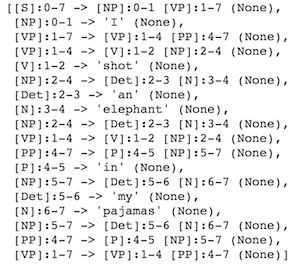  
(Note that the rule probabilities are set to `None`. These are not saved in the backpointer chart so cannot be retrieved at the recovering stage. They also don't matter at this point, so you can set them to `None`.)

If you give this derivation to the function `make_nltk_tree` and then let NLTK draw it, then you get this tree:

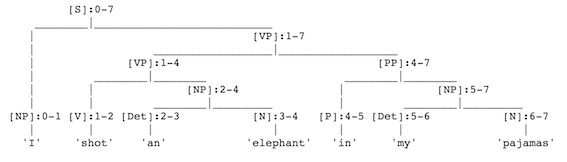

### The exercise

In [ ]:
def build_tree(back, sentence, root, n2i):
    """
    Reconstruct the viterbi parse from a filled-in backpointer chart.
    
    It returns a list called derivation which holds the rules over Spans.
    If you want to use the function make_nltk_tree you must make sure that
    the order in derivation follows the depth-first order.
    
    :param back: a backpointer chart of shape [num_nonterminals, num_words+1, num_words+1]
    :param sentence: a list of words
    :param root: the root symbol of the tree: Nonterminal('S')
    :param n2i: the dictionary mapping from Nonterminals to indices
    :return derivation: a derivation: a list of Rules with Span symbols that generate the Viterbi tree. 
                        If you want to draw them with the function that we provide, then this list 
                        should be ordered depth first!
    """
    derivation = []
    num_words = len(sentence)

    #YOUR CODE HERE
    def cycle(start_1, start, end):
        back_point = back[n2i[start_1]][start][end]
        if isinstance(back_point, tuple):
            split = back_point[0]
            start_2 = back_point[1]
            end_2 = back_point[2]
            derivation.append(Rule(Span(start_1, start, end), [Span(start_2, start, split), Span(end_2, split, end)], prob=None))
            cycle(start_2, start, split)
            cycle(end_2, split, end)
        else:
            derivation.append(Rule(Span(start_1, start, end), [Span(back_point, start, end)], prob=None))
    
    start = 0
    end = num_words
    back_point = back[n2i[root]][start][end]
    
    split = back_point[0]
    start_1 = back_point[1]
    end_1 = back_point[2]
    derivation.append(Rule(Span(root, start, end), [Span(start_1, start, split),Span(end_1, split, end)], prob=None))
    
    
    cycle(start_1, start, split)
    cycle(end_1, split, end)
    
    return derivation

Get your derivation:

In [ ]:
derivation = build_tree(back, sentence, S, n2i)
derivation

[[S]:0-7 -> [NP]:0-1 [VP]:1-7 (None),
 [NP]:0-1 -> 'I' (None),
 [VP]:1-7 -> [VP]:1-4 [PP]:4-7 (None),
 [VP]:1-4 -> [V]:1-2 [NP]:2-4 (None),
 [V]:1-2 -> 'shot' (None),
 [NP]:2-4 -> [Det]:2-3 [N]:3-4 (None),
 [Det]:2-3 -> 'an' (None),
 [N]:3-4 -> 'elephant' (None),
 [PP]:4-7 -> [P]:4-5 [NP]:5-7 (None),
 [P]:4-5 -> 'in' (None),
 [NP]:5-7 -> [Det]:5-6 [N]:6-7 (None),
 [Det]:5-6 -> 'my' (None),
 [N]:6-7 -> 'pajamas' (None)]

Turn the derivation into an NLTK tree:

In [ ]:
def make_nltk_tree(derivation):
    """
    Return a NLTK Tree object based on the derivation
    (list or tuple of Rules)
    """
    d = defaultdict(None, ((r.lhs, r.rhs) for r in derivation))

    def make_tree(lhs):
        return Tree(str(lhs), (str(child) if child not in d else make_tree(child) for child in d[lhs]))

    return make_tree(derivation[0].lhs)

tree = make_nltk_tree(derivation)
tree.pretty_print()

         [S]:0-7                                                                   
    ________|___________________________                                            
   |                                 [VP]:1-7                                      
   |                  __________________|__________________                         
   |              [VP]:1-4                              [PP]:4-7                   
   |         ________|________                     ________|________                
   |        |              [NP]:2-4               |              [NP]:5-7          
   |        |         ________|_________          |         ________|_________      
[NP]:0-1 [V]:1-2 [Det]:2-3           [N]:3-4   [P]:4-5 [Det]:5-6           [N]:6-7 
   |        |        |                  |         |        |                  |     
  'I'     'shot'    'an'            'elephant'   'in'     'my'            'pajamas'



# That's it!

Congratulations, you have made it to the end of the lab.

**Make sure all your cells are executed so that all your answers are there. Then, continue if you're interested!**

----

# Optional

If you managed to get your entire CKY-parser working and have an appetite for more, it might be fun to try it on some more sentences and grammars. Give the grammars below a try!

### Alternative Groucho-grammar

If you change the probabilities in the grammar, you'll get a different parse as the most likely one. Compare `groucho-grammar-1.txt` with `groucho-grammar-2.txt` and spot the difference in probabilities.

In [ ]:
#YOUR CODE HERE
istream_2 = open('groucho-grammar-2.txt')
grammar_2 = PCFG(read_grammar_rules(istream_2))
print(grammar_2)

score_2, back_2 = cky(sentence, grammar_2, n2i)
derivation_2 = build_tree(back_2, sentence, S, n2i)
tree_2 = make_nltk_tree(derivation_2)
tree_2.pretty_print()

[S] -> [NP] [VP] (1.0)
[PP] -> [P] [NP] (1.0)
[NP] -> [Det] [N] (0.2)
[NP] -> [Det] [NP] (0.3)
[NP] -> [N] [PP] (0.3)
[NP] -> 'I' (0.2)
[VP] -> [V] [NP] (0.6)
[VP] -> [VP] [PP] (0.4)
[Det] -> 'an' (0.6)
[Det] -> 'my' (0.4)
[N] -> 'elephant' (0.5)
[N] -> 'pajamas' (0.5)
[V] -> 'shot' (1.0)
[P] -> 'in' (1.0)
         [S]:0-7                                                                    
    ________|__________________                                                      
   |                        [VP]:1-7                                                
   |         __________________|_________                                            
   |        |                         [NP]:2-7                                      
   |        |         ___________________|________                                   
   |        |        |                         [NP]:3-7                             
   |        |        |          __________________|_________                         
   |    

**Difference**:

### The man with the telescope

Another ambiguous sentence:

> I saw the man on the hill with the telescope.

A grammar for this sentence is specified in the file `telescope-grammar.txt`.

In [ ]:
#YOUR CODE HERE
sentence_3 = "I saw the man on the hill with the telescope".split()

istream_3 = open('telescope-grammar.txt')
grammar_3 = PCFG(read_grammar_rules(istream_3))
print(grammar_3)

score_3, back_3 = cky(sentence_3, grammar_3, n2i)
derivation_3 = build_tree(back_3, sentence_3, S, n2i)
tree_3 = make_nltk_tree(derivation_3)
tree_3.pretty_print()

[S] -> [NP] [VP] (1.0)
[VP] -> [V] [NP] (0.6)
[VP] -> [VP] [PP] (0.4)
[NP] -> [NP] [PP] (0.3)
[NP] -> [Det] [N] (0.3)
[NP] -> [Det] [NP] (0.2)
[NP] -> 'I' (0.2)
[PP] -> [P] [NP] (0.8)
[PP] -> [PP] [PP] (0.2)
[V] -> 'saw' (1.0)
[Det] -> 'the' (1.0)
[N] -> 'man' (0.4)
[N] -> 'hill' (0.3)
[N] -> 'telescope' (0.3)
[P] -> 'on' (0.5)
[P] -> 'with' (0.5)
                                             [S]:0-10                                                                   
    ____________________________________________|_________                                                               
   |                                                  [VP]:1-10                                                         
   |                                    __________________|__________________________________                            
   |                                [VP]:1-7                                                 |                          
   |                  _________________|___